In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import math
from statistics import mean
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
from datetime import timedelta
from sklearn.metrics import mean_squared_error


#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam


from sklearn.model_selection import train_test_split

import category_encoders as ce

In [189]:
status = pd.read_csv('status.csv')
station = pd.read_csv('station.csv')
weather = pd.read_csv('weather.csv')
trip = pd.read_csv('trip.csv')

In [190]:
status['date'] = status['year'].astype(str) + '/' + status['month'].astype(str).str.zfill(2).astype(str) + '/' + status['day'].astype(str).str.zfill(2).astype(str)
status['date'] = pd.to_datetime(status['date'])
status.head()

,id,year,month,day,hour,station_id,bikes_available,predict,date
0,0,2013,9,1,0,0,11.0,0,2013-09-01
1,1,2013,9,1,1,0,11.0,0,2013-09-01
2,2,2013,9,1,2,0,11.0,0,2013-09-01
3,3,2013,9,1,3,0,11.0,0,2013-09-01
4,4,2013,9,1,4,0,11.0,0,2013-09-01


In [191]:
#statusにstationのstation_idをマージ
#status = pd.merge(status, station[['station_id', 'city']], how = 'left')

#曜日を追加するための関数を定義
def get_weekday_jp(dt):
    w_list = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
    return(w_list[dt.weekday()])

#dateから曜日情報を取得
status["weekday"] = status["date"].apply(get_weekday_jp)
print(status.head(10))
'''
#statusのdate列の曜日を数値化
status['week_num'] = status['date'].dt.weekday
status.head()
'''

   id  year  month  day  hour  station_id  bikes_available  predict  \
0   0  2013      9    1     0           0             11.0        0   
1   1  2013      9    1     1           0             11.0        0   
2   2  2013      9    1     2           0             11.0        0   
3   3  2013      9    1     3           0             11.0        0   
4   4  2013      9    1     4           0             11.0        0   
5   5  2013      9    1     5           0             11.0        0   
6   6  2013      9    1     6           0             11.0        0   
7   7  2013      9    1     7           0             11.0        0   
8   8  2013      9    1     8           0             11.0        0   
9   9  2013      9    1     9           0             11.0        0   

        date weekday  
0 2013-09-01     日曜日  
1 2013-09-01     日曜日  
2 2013-09-01     日曜日  
3 2013-09-01     日曜日  
4 2013-09-01     日曜日  
5 2013-09-01     日曜日  
6 2013-09-01     日曜日  
7 2013-09-01     日曜日  
8 2013-09-0

"\n#statusのdate列の曜日を数値化\nstatus['week_num'] = status['date'].dt.weekday\nstatus.head()\n"

In [192]:
weather['date'] = pd.to_datetime(weather['date'])
#weatherのprecipitationをマージ
status = pd.merge(status, weather[['date', 'precipitation']], how = 'left')
status.head()

,id,year,month,day,hour,station_id,bikes_available,predict,date,weekday,precipitation
0,0,2013,9,1,0,0,11.0,0,2013-09-01,日曜日,0.0
1,1,2013,9,1,1,0,11.0,0,2013-09-01,日曜日,0.0
2,2,2013,9,1,2,0,11.0,0,2013-09-01,日曜日,0.0
3,3,2013,9,1,3,0,11.0,0,2013-09-01,日曜日,0.0
4,4,2013,9,1,4,0,11.0,0,2013-09-01,日曜日,0.0


In [193]:
#main = status[["date","hour","station_id","bikes_available","predict", 'week_num']]

#これから細かい前処理をするためにmain_dfを作成
main = status[["date","hour","station_id","bikes_available","weekday","predict"]]
main.head()

,date,hour,station_id,bikes_available,weekday,predict
0,2013-09-01,0,0,11.0,日曜日,0
1,2013-09-01,1,0,11.0,日曜日,0
2,2013-09-01,2,0,11.0,日曜日,0
3,2013-09-01,3,0,11.0,日曜日,0
4,2013-09-01,4,0,11.0,日曜日,0


In [194]:
#カテゴリ変数をダミー変数化
main = pd.get_dummies(main)
print(main.columns)
print(main.shape)

Index(['date', 'hour', 'station_id', 'bikes_available', 'predict',
       'weekday_土曜日', 'weekday_日曜日', 'weekday_月曜日', 'weekday_木曜日',
       'weekday_水曜日', 'weekday_火曜日', 'weekday_金曜日'],
      dtype='object')
(1226400, 12)


In [195]:
#学習用のデータフレームを作成
train_dataset_df = main[main["date"]<"2014-09-01"]
#評価用のデータフレームを作成(使用するモデルの関係上、前日のデータが必要なため2014-08-31から取得)
evaluation_dataset_df = main[main["date"]>="2014-08-31"]

In [196]:
#各ステーション毎に、欠損値を後の値で埋める。あとというのはbfillのとこ
train_dataset_df_new = pd.DataFrame()
for station_id in train_dataset_df["station_id"].unique().tolist():
    temp_df = train_dataset_df[train_dataset_df["station_id"]==station_id]
    temp_df = temp_df.fillna(method="bfill")
    train_dataset_df_new = pd.concat([train_dataset_df_new,temp_df])

print(train_dataset_df_new.isnull().sum())

date               0
hour               0
station_id         0
bikes_available    0
predict            0
weekday_土曜日        0
weekday_日曜日        0
weekday_月曜日        0
weekday_木曜日        0
weekday_水曜日        0
weekday_火曜日        0
weekday_金曜日        0
dtype: int64


In [197]:
#データセットを時系列に並び替える(後ほど説明)
train_df = train_dataset_df_new.sort_values(["date","hour","station_id"],ascending=True).reset_index(drop=True)
evaluation_dataset_df = evaluation_dataset_df.sort_values(["date","hour","station_id"],ascending=True).reset_index(drop=True)
#学習用データセット
train_df.head()

,date,hour,station_id,bikes_available,predict,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
0,2013-09-01,0,0,11.0,0,0,1,0,0,0,0,0
1,2013-09-01,0,1,8.0,0,0,1,0,0,0,0,0
2,2013-09-01,0,2,5.0,0,0,1,0,0,0,0,0
3,2013-09-01,0,3,9.0,0,0,1,0,0,0,0,0
4,2013-09-01,0,4,8.0,0,0,1,0,0,0,0,0


In [198]:
print(train_df.shape, evaluation_dataset_df.shape)

(613200, 12) (614880, 12)


In [199]:
#predictは特徴量として必要ないため、削除
train_df = train_df.drop("predict",axis=1)
train_df.head()

,date,hour,station_id,bikes_available,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
0,2013-09-01,0,0,11.0,0,1,0,0,0,0,0
1,2013-09-01,0,1,8.0,0,1,0,0,0,0,0
2,2013-09-01,0,2,5.0,0,1,0,0,0,0,0
3,2013-09-01,0,3,9.0,0,1,0,0,0,0,0
4,2013-09-01,0,4,8.0,0,1,0,0,0,0,0


In [200]:
train_df

,date,hour,station_id,bikes_available,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
0,2013-09-01,0,0,11.0,0,1,0,0,0,0,0
1,2013-09-01,0,1,8.0,0,1,0,0,0,0,0
2,2013-09-01,0,2,5.0,0,1,0,0,0,0,0
3,2013-09-01,0,3,9.0,0,1,0,0,0,0,0
4,2013-09-01,0,4,8.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
613195,2014-08-31,23,65,10.0,0,1,0,0,0,0,0
613196,2014-08-31,23,66,9.0,0,1,0,0,0,0,0
613197,2014-08-31,23,67,7.0,0,1,0,0,0,0,0
613198,2014-08-31,23,68,8.0,0,1,0,0,0,0,0


In [201]:
evaluation_dataset_df

,date,hour,station_id,bikes_available,predict,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
0,2014-08-31,0,0,11.0,0,0,1,0,0,0,0,0
1,2014-08-31,0,1,9.0,0,0,1,0,0,0,0,0
2,2014-08-31,0,2,4.0,0,0,1,0,0,0,0,0
3,2014-08-31,0,3,8.0,0,0,1,0,0,0,0,0
4,2014-08-31,0,4,7.0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
614875,2015-08-31,23,65,13.0,0,0,0,1,0,0,0,0
614876,2015-08-31,23,66,7.0,0,0,0,1,0,0,0,0
614877,2015-08-31,23,67,6.0,0,0,0,1,0,0,0,0
614878,2015-08-31,23,68,5.0,0,0,0,1,0,0,0,0


In [186]:
#今回LSTMモデルを使用するため、データを標準化
#特徴量を標準化するための変数
scaler = MinMaxScaler(feature_range=(0, 1))
#標準化された出力をもとにスケールに変換(inverse)するために必要な変数
scaler_for_inverse = MinMaxScaler(feature_range=(0, 1))
train_df_scale = scaler.fit_transform(train_df.iloc[:,3:])
bikes_available_scale = scaler_for_inverse.fit_transform(train_df[["bikes_available"]])
print(train_df_scale.shape)

(613200, 8)


In [203]:
'''
length = len(train_df_scale)
train_size = int(length * 0.8)
test_size = length - train_size
train, test = train_df_scale[0:train_size,:], train_df_scale[train_size:length,:]


def create_dataset(dataset):
    dataX = []
    dataY = np.array([])
    #1680で1つのデータセットであるため、余りの分は使わない
    extra_num = len(dataset) % 70
    max_len = len(dataset)-extra_num
    for i in range(1680,max_len,70):
        xset = []
        for j in range(dataset.shape[1]):
            a = dataset[i-1680:i, j]
            xset.append(a)
        temp_array = np.array(dataset[i:i+70,0])
        dataY = np.concatenate([dataY,temp_array])
        dataX.append(xset)
    dataY = dataY.reshape(-1,70)
    return np.array(dataX), dataY 
trainX, trainY = create_dataset(train)
testX, testY = create_dataset(test)

#lightGBMのモデルに入力用にデータの形を整形
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))


#入力データと正解データの形を確認
print(trainX.shape)
print(trainY.shape)

print(testX.shape)
print(testY.shape)
'''

train = train_df
test = evaluation_dataset_df

print(train.shape)
print(test.shape)

(613200, 11)
(614880, 12)


In [165]:
trainX

array([[[0.40740741, 0.2962963 , 0.18518519, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.40740741, 0.2962963 , 0.18518519, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [1.        , 1.        , 1.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

In [182]:
# トレーニングデータ,テストデータの分割
X_train, X_test, y_train, y_test = train_test_split(tr, test ,test_size=0.20, random_state=2)

In [183]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(98112, 8) (98112, 8) (24528, 8) (24528, 8)


In [185]:
print(X_train.max(), y_train.max(), X_test.max(), y_test.max())

1.0 1.0 1.0 1.0


# lightGBM

In [49]:
pip install lightgbm

     |████████████████████████████████| 2.0 MB 1.7 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [51]:
import lightgbm as lgb #LightGBM
# データフレームを綺麗に出力する関数
import IPython
def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

from sklearn.metrics import r2_score # モデル評価用(決定係数)
import seaborn as sns; sns.set() # グラフ描画用

In [187]:
# モデルの学習
model = lgb.LGBMRegressor() # モデルのインスタンスの作成
model.fit(X_train, y_train) # モデルの学習

#X_train, X_test, y_train, y_test

# テストデータの予測
y_pred = model.predict(X_test)

ValueError: bad input shape (98112, 8)

# LSTM

In [180]:
#今回LSTMモデルを使用するため、データを標準化
#特徴量を標準化するための変数
scaler = MinMaxScaler(feature_range=(0, 1))
#標準化された出力をもとにスケールに変換(inverse)するために必要な変数
scaler_for_inverse = MinMaxScaler(feature_range=(0, 1))
train_df_scale = scaler.fit_transform(train_df.iloc[:,3:])
bikes_available_scale = scaler_for_inverse.fit_transform(train_df[["bikes_available"]])
print(train_df_scale.shape)

(613200, 8)


In [45]:
#学習用のデータをモデルの学習用とモデルの精度の検証用に分割
#今回は、モデル用学習データ:精度用の検証データ = 7 : 3 に分割
length = len(train_df_scale)
train_size = int(length * 0.7)
test_size = length - train_size
train, test = train_df_scale[0:train_size,:], train_df_scale[train_size:length,:]
print(train.shape)
print(test.shape)


def create_dataset(dataset):
    dataX = []
    dataY = np.array([])
    #1680で1つのデータセットであるため、余りの分は使わない
    extra_num = len(dataset) % 70
    max_len = len(dataset)-extra_num
    for i in range(1680,max_len,70):
        xset = []
        for j in range(dataset.shape[1]):
            a = dataset[i-1680:i, j]
            xset.append(a)
        temp_array = np.array(dataset[i:i+70,0])
        dataY = np.concatenate([dataY,temp_array])
        dataX.append(xset)
    dataY = dataY.reshape(-1,70)
    return np.array(dataX), dataY 

(429240, 8)
(183960, 8)


In [46]:
trainX, trainY = create_dataset(train)
testX, testY = create_dataset(test)


In [ ]:
#LSTMのモデルに入力用にデータの形を整形
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))
#入力データと正解データの形を確認
print(trainX.shape)
print(trainY.shape)

In [14]:
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1],1680)))
model.add(Dense(70))
model.compile(loss='mean_squared_error', optimizer='adam')



In [ ]:

#これ超絶重い。dockerのメモリもっと必要かも
hist = model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

In [15]:
#学習済みモデルで予測
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

#スケールをもとに戻す
train_predict = scaler_for_inverse.inverse_transform(train_predict)
trainY = scaler_for_inverse.inverse_transform(trainY)
test_predict = scaler_for_inverse.inverse_transform(test_predict)
testY = scaler_for_inverse.inverse_transform(testY)

#各ステーションのスコアの平均値を算出
train_score_list = []
test_score_list = []
for i in range(70):
    trainscore = math.sqrt(mean_squared_error(trainY[:,i], train_predict[:,i]))
    train_score_list.append(trainscore)
    testscore = math.sqrt(mean_squared_error(testY[:,i], test_predict[:,i]))
    test_score_list.append(testscore)

#チュートリアルのまんまでtrain:2.408、test:3.120くらい
#train:test比を8:2から7:3にするとtarin:2.48、test:3.13と悪化
#LSTMでget_dummiesなくすとtrain:2.23, test:2.785くらい。過学習
print("trainのRMSE平均 : ",mean(train_score_list))
print("testのRMSE平均 : ",mean(test_score_list))

trainのRMSE平均 :  9.467441766370095
testのRMSE平均 :  9.390878466907383


In [16]:
#予測日とその前日を含むデータフレームを作成すると前日の日付データを返す関数
def make_sameday_thedaybefore_dataset(dataset,prediction_date):
    #前日の日付をtimedeltaで取得
    before_date = prediction_date - timedelta(days=1)
    prediction_date = str(prediction_date).split(" ")[0]
    before_date = str(before_date).split(" ")[0]
    #予測日とその前日を含むものだけを抽出
    temp_dataset = dataset[dataset["date"].isin([before_date,prediction_date])]
        
    return before_date,temp_dataset


#評価用のデータセットを作成する関数
def make_evaluation_dataset(dataset):
    output_df = pd.DataFrame()
    prediction_date_list = dataset[dataset["predict"]==1]["date"].tolist()
    for date in sorted(list(set(prediction_date_list))):
        before_date,temp_dataset = make_sameday_thedaybefore_dataset(dataset,date)
        #前日のbikes_availableに欠損値が含まれるかどうかの判定
        if temp_dataset[temp_dataset["date"]==before_date]["bikes_available"][1:].isnull().any(): 
            #各ステーションで予測日の０時で前日の1時以降のデータを置換
            #予測日のbikes_availableの置換は、後ほど別途処理するので今回は無視
            temp_dataset = temp_dataset.sort_values(["station_id","date","hour"]).fillna(method="bfill")
            temp_dataset = temp_dataset.sort_values(["date","hour","station_id"],ascending=True)
            #予測には、前日の1時からのデータしか使用しないので、0時のデータは除く
            output_df = pd.concat([output_df,temp_dataset.iloc[70:,:]])
        else: #欠損値なし　→ そのまま前日分のデータを利用
            output_df = pd.concat([output_df,temp_dataset.iloc[70:,:]])
        
    return output_df

#予測日とその前日を含むデータフレームを作成する関数
def make_sameday_thedaybefore_dataset(dataset,prediction_date):
    #前日の日付をtimedeltaで取得
    before_date = prediction_date - timedelta(days=1)
    prediction_date = str(prediction_date).split(" ")[0]
    before_date = str(before_date).split(" ")[0]
    #予測日とその前日を含むものだけを抽出
    temp_dataset = dataset[dataset["date"].isin([before_date,prediction_date])]
        
    return temp_dataset

#評価用のデータセットを作成する関数
def make_evaluation_dataset(dataset):
    output_df = pd.DataFrame()
    prediction_date_list = dataset[dataset["predict"]==1]["date"].tolist()
    for date in sorted(list(set(prediction_date_list))):
        #前日の日付をtimedeltaで取得
        before_date = date - timedelta(days=1)
        date = str(date).split(" ")[0]
        before_date = str(before_date).split(" ")[0]
        temp_dataset = dataset[dataset["date"].isin([before_date,date])]
        #前日のbikes_availableに欠損値が含まれるかどうかの判定
        if temp_dataset[temp_dataset["date"]==before_date]["bikes_available"][1:].isnull().any(): 
            #各ステーションで予測日の０時で前日の1時以降のデータを置換
            #予測日のbikes_availableの置換は、後ほど別途処理するので今回は無視
            temp_dataset = temp_dataset.sort_values(["station_id","date","hour"]).fillna(method="bfill")
            temp_dataset = temp_dataset.sort_values(["date","hour","station_id"],ascending=True)
            #予測には、前日の1時からのデータしか使用しないので、0時のデータは除く
            output_df = pd.concat([output_df,temp_dataset.iloc[70:,:]])
        else: #欠損値なし　→ そのまま前日分のデータを利用
            output_df = pd.concat([output_df,temp_dataset.iloc[70:,:]])
        
    return output_df

In [17]:
#評価用のデータセット
evaluation_df = make_evaluation_dataset(evaluation_dataset_df)
evaluation_df.head()

,date,hour,station_id,bikes_available,predict,week_num
70,2014-08-31,1,0,11.0,0,6
71,2014-08-31,1,1,9.0,0,6
72,2014-08-31,1,2,4.0,0,6
73,2014-08-31,1,3,8.0,0,6
74,2014-08-31,1,4,7.0,0,6


In [18]:

#LSTMの出力結果でデータを補完しながら、提出用データフレームを作成する関数
def predict_eva_dataset(eva_dataset):
    submission_df = pd.DataFrame()
    #予測したbikes_availableを元のスケールに戻すための変数
    scaler_for_inverse = MinMaxScaler(feature_range=(0, 1))
    scale_y = scaler_for_inverse.fit_transform(eva_dataset[["bikes_available"]])
    prediction_date_list = eva_dataset[eva_dataset["predict"]==1]["date"].tolist()
    for date in sorted(list(set(prediction_date_list))):
        temp_eva_dataset = make_sameday_thedaybefore_dataset(eva_dataset,date)
        for i in range(0,1610,70):
            #モデルに入れるためのデータセット(1680×colu}mns)
            temp_eva_dataset_train = temp_eva_dataset.iloc[i:1680+i,:]
            #predictは特徴量に使わないため、ここで削除
            temp_eva_dataset_train = temp_eva_dataset_train.drop("predict",axis=1)
            #データを標準化する
            scaler = MinMaxScaler(feature_range=(0, 1))
            temp_eva_dataset_scale = scaler.fit_transform(temp_eva_dataset_train.iloc[:,3:])
            
            #モデルに入力する形にデータを整形
            train = []
            xset = []
            for j in range(temp_eva_dataset_scale.shape[1]):
                a = temp_eva_dataset_scale[:, j]
                xset.append(a)
            train.append(xset)
            train = np.array(train)
            train = np.reshape(train, (train.shape[0], train.shape[1], train.shape[2]))
            
            #学習済みlstmモデルで予測
            predict_scale = model.predict(train)
            predict = scaler_for_inverse.inverse_transform(predict_scale)

            #次に使うbikes_availableに出力結果を補完
            temp_eva_dataset.iloc[1680+i:1750+i,3] = predict[0]

        submission_df= pd.concat([submission_df,temp_eva_dataset.iloc[1610:,:]])
        
    return submission_df

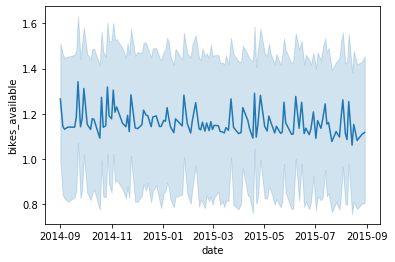

In [19]:
#予測した結果を時系列で可視化して確認
submission_df = predict_eva_dataset(evaluation_df)
sns.lineplot(x ='date', y ='bikes_available',data = submission_df)

In [23]:
lstm_submit_df = submission_df[submission_df["predict"]==1].sort_values(["station_id","date"])[["bikes_available"]]
lstm_submit_df["bikes_available"] = lstm_submit_df["bikes_available"].map(lambda x:0 if x < 0 else x)
lstm_submit_df.index = status[status["predict"]==1].index
lstm_submit_df.to_csv("lstm_submission.csv",header=None)#.head()